In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import LeakyReLU



In [79]:
im_width = 128
im_height = 128
border = 5
path_train_input = '/content/drive/My Drive/Ag-Net-Dataset-master/input/'
path_train_output = '/content/drive/My Drive/Ag-Net-Dataset-master/target/'

#ids_in=[]
#ids_out=[]


ids = next(os.walk(path_train_output))[2]
print(len(ids))

#for id_ in ids:
  #for i in range(1,8):
    #ids_in.append(path_train_input + 'lc8' + id_[3:-4] + '_' + str(i) + '.tif')
    #ids_out.append(path_train_output + id_)
    

from random import shuffle

#c = list(zip(ids_in, ids_out))

shuffle(ids)

#ids_in,ids_out=zip(*c)

train_ids = ids[0:1500]
valid_ids = ids[1500:]

#valid_ids_out = ids_out[0:int(0.15*len(ids_out))]
#train_ids_out = ids_out[int(0.15*len(ids_out)):]""""

print(len(train_ids))
    


1593
1500


In [80]:
print(path_train_input+train_ids[0])

/content/drive/My Drive/Ag-Net-Dataset-master/input/cdl_2015245_37_21.tif


In [0]:

    
def get_data(ids,batch_size):
  while True:
    ids_batches = [ids[i:min(i+batch_size,len(ids))] for i in range(0, len(ids), batch_size)] 
    #ids_out_batches = [ids_out[j:min(j+batch_size,len(ids_out))] for j in range(0, len(ids_out), batch_size)]
    # Load images
    for b in range(len(ids_batches)):
      #print(b)
      #print(":")
      #print(ids_batches[b])
      k=-1
      X = np.zeros((len(ids_batches[b]), im_height, im_width, 7), dtype=np.float32)
      y = np.zeros((len(ids_batches[b]), im_height*im_width, 255), dtype=np.float32)
      for c in range(len(ids_batches[b])):
        k=k+1
        #temp1=np.zeros((1,7),dtype=np.float32)
        for r in range(1,7):
          img = load_img(path_train_input + 'lc8' + ids_batches[b][c][3:-4] + '_' + str(r) + '.tif', color_mode="grayscale")
          x_img = img_to_array(img)
          x_img = resize(x_img, (128, 128), mode='constant', preserve_range=True)
          for p in range(128):
            for q in range(128):
              #print(x_img[p][q]/255)
              X[k][p][q][r-1]=x_img[p][q]/255
          
        #k=k+1
        # Save images
        #X[k, ..., 0] = temp1 / 255  

        # Load masks

        mask = img_to_array(load_img(path_train_output+ids_batches[b][c], color_mode="grayscale"))
        mask = resize(mask, (128, 128), mode='constant', preserve_range=True)
        
        inc=-1
        for p in range(128):
          for q in range(128):
            num=int(mask[p][q])
            temp=np.zeros((255), dtype=np.float32)
            temp[num]=1
            inc=inc+1
            y[k][inc]=temp
            print

      yield X,y          

  

    
#, kernel_initializer="he_normal"


In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3,strides=1,batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),strides=(strides, strides),padding="same", kernel_initializer="he_normal")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
#     # second layer
#     x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),strides=(strides, strides),padding="same", kernel_initializer="he_normal")(x)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     #x = MaxPooling2D((2, 2)) (x)
# #     p2 = Dropout(rate=dropout)(p2)
    return x
  

def encoder_decoder(x1,ni, kernel_size=3, batchnorm=True,times=None):
  x=GlobalMaxPooling2D()(x1)
  x=Reshape(target_shape=(1,1,times))(x)
  x=Conv2D(filters=ni//2, kernel_size=(kernel_size, kernel_size),padding="same", kernel_initializer="he_normal")(x)
  x=LeakyReLU(alpha=0.1)(x)
  x=Conv2D(filters=ni, kernel_size=(kernel_size, kernel_size),padding="same", kernel_initializer="he_normal")(x)
  x=Activation('sigmoid')(x)
  
  x2=Conv2D(filters=ni, kernel_size=(kernel_size, kernel_size),padding="same", kernel_initializer="he_normal")(x1)
  x2=Activation('sigmoid')(x2)
  
  
  x11=Multiply()([x1,x2])
  x12=Multiply()([x1,x])
  x13=Add()([x11,x12])
  
  return x13
  
  
 
  
  
def DownBlock(x,ni,nf, kernel_size=3, batchnorm=True,down=None):
  inp=x
  x=conv2d_block(x,nf,3,2)
  x=conv2d_block(x,nf,3)
  x=Add()([x,conv2d_block(inp,nf,3,2)])
  if down is not None:
    return encoder_decoder(x,nf, kernel_size=3, batchnorm=True,times=128)
  else:
    return x
  
def UpBlock(down,cross,ni,nf, kernel_size=3, batchnorm=True,down1=None):
  x=Conv2DTranspose(filters=nf, kernel_size=(3, 3),strides=(2,2),padding="same", kernel_initializer="he_normal")(down)
  print(x)
  print(cross)
  x=concatenate([x,cross])
  x=conv2d_block(x,nf,3)
  if down1 is not None:
    return encoder_decoder(x,nf, kernel_size=3, batchnorm=True,times=256)
  else:
    return x
  
  
    

In [0]:
from keras.activations import softmax
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout,GlobalMaxPooling2D
from keras.layers import Add,Multiply
from keras import backend as K





#print(y_train)


In [0]:
def get_unet(input_img, n_filters=128, dropout=0.15, batchnorm=True):
#     # contracting path
#     c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
#     p1 = MaxPooling2D((2, 2)) (c1)
#     p1 = Dropout(rate=dropout*0.5)(p1)
    
#     c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
#     p2 = MaxPooling2D((2, 2)) (c2)
#     p2 = Dropout(rate=dropout)(p2)


    
#     c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
#     # expansive path
#     u4 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c3)
#     u4 = concatenate([u4, c2])
#     u4 = Dropout(rate=dropout)(u4)
#     c4 = conv2d_block(u4, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
#     u5 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c4)
#     u5 = concatenate([u5, c1])
#     u5 = Dropout(rate=dropout)(u5)
#     c5 = conv2d_block(u5, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    
#     c6 = conv2d_block(c5, n_filters=255, kernel_size=1, batchnorm=batchnorm)
    
#     c7 = core.Reshape((128*128,255))(c6)
    

#     #Conv2D(255, (1, 1), activation='softmax') (c4)
    
#     outputs = core.Activation('softmax')(c7)
    
#     #outputs=Lambda(lambda x: x ** 0.5)(outputs)



  d1=DownBlock(input_img,7,128,3, True,12)
  print("D1")
  d2=DownBlock(d1,128,256)
  print("D2")
  d3=DownBlock(d2,256,512)
  print("D3")
  d4=DownBlock(d3,512,1024)
  print("D4")
  print(d4)
  u1=UpBlock(d4,d3,1024,512)
  print("U1")
  u2=UpBlock(u1,d2,512,256,3,True,12)
  print("U2")
  u3=UpBlock(u2,d1,256,128)
  print("U3")
  
  print("X")
  print(u3)
  
  outputs = Conv2DTranspose(filters=255, kernel_size=(3,3),strides=(2,2),padding="same", kernel_initializer="he_normal")(u3)
  print("Yes")
  outputs = core.Reshape((128*128,255))(outputs)
  outputs = core.Activation('softmax')(outputs)
  
  
  
  
  
    
  model = Model(inputs=[input_img], outputs=[outputs])
  print("Yes1")
  return model
	

In [85]:
input_img = Input((128, 128, 7), name='img')
model = get_unet(input_img, n_filters=7, dropout=0.15, batchnorm=True)
#model = get_unet()

model.compile(optimizer=Adam(lr=0.1), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
model.summary()

D1
D2
D3
D4
Tensor("add_23/add:0", shape=(?, 8, 8, 1024), dtype=float32)
Tensor("conv2d_transpose_13/BiasAdd:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("add_22/add:0", shape=(?, 16, 16, 512), dtype=float32)
U1
Tensor("conv2d_transpose_14/BiasAdd:0", shape=(?, ?, ?, 256), dtype=float32)
Tensor("add_21/add:0", shape=(?, 32, 32, 256), dtype=float32)
U2
Tensor("conv2d_transpose_15/BiasAdd:0", shape=(?, ?, ?, 128), dtype=float32)
Tensor("add_20/add:0", shape=(?, 64, 64, 128), dtype=float32)
U3
X
Tensor("leaky_re_lu_68/LeakyRelu:0", shape=(?, 64, 64, 128), dtype=float32)
Yes
Yes1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 7)  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)

In [0]:
callbacks = [
    EarlyStopping(monitor='loss',patience=10, verbose=1),
    ReduceLROnPlateau(monitor='loss',factor=0.1, patience=3, min_lr=0.00000001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/model3.h5', monitor='loss',verbose=1, save_best_only=True, save_weights_only=False)
]



In [0]:
train_generator = get_data(train_ids[0:1], batch_size=1)
valid_generator = get_data(valid_ids[0:1],batch_size=1)


In [0]:
def get_data1(ids,batch_size):
    ids_batches = [ids[i:min(i+batch_size,len(ids))] for i in range(0, len(ids), batch_size)] 
    #ids_out_batches = [ids_out[j:min(j+batch_size,len(ids_out))] for j in range(0, len(ids_out), batch_size)]
    # Load images
    for b in range(len(ids_batches)):
      #print(b)
      #print(":")
      #print(ids_batches[b])
      k=-1
      X = np.zeros((len(ids_batches[b]), im_height, im_width, 7), dtype=np.float32)
      y = np.zeros((len(ids_batches[b]), im_height*im_width, 255), dtype=np.float32)
      for c in range(len(ids_batches[b])):
        k=k+1
        #temp1=np.zeros((1,7),dtype=np.float32)
        for r in range(1,7):
          img = load_img(path_train_input + 'lc8' + ids_batches[b][c][3:-4] + '_' + str(r) + '.tif', color_mode="grayscale")
          x_img = img_to_array(img)
          x_img = resize(x_img, (128, 128), mode='constant', preserve_range=True)
          for p in range(128):
            for q in range(128):
              #print(x_img[p][q]/255)
              X[k][p][q][r-1]=x_img[p][q]/255
          
        #k=k+1
        # Save images
        #X[k, ..., 0] = temp1 / 255  

        # Load masks

        mask = img_to_array(load_img(path_train_output+ids_batches[b][c], color_mode="grayscale"))
        mask = resize(mask, (128, 128), mode='constant', preserve_range=True)
        
        inc=-1
        for p in range(128):
          for q in range(128):
            num=int(mask[p][q])
            temp=np.zeros((255), dtype=np.float32)
            temp[num]=1
            inc=inc+1
            y[k][inc]=temp
            print

      return X,y          


In [0]:
x_tr,y_tr=get_data1(train_ids[0:2], batch_size=2)

In [0]:
results =model.fit(x=x_tr,y=y_tr, batch_size=1 , epochs=500, verbose=1)

In [0]:
#new_model.predict_generator(train_generator,steps=2,verbose=1)
results =model.fit_generator(train_generator, steps_per_epoch=10 , epochs=500, verbose=1, validation_data=valid_generator, validation_steps=1, callbacks=callbacks)

In [0]:
model.evaluate(x=x_tr,y=y_tr,batch_size=1)

In [153]:
print(y_tr.shape)

(2, 16384, 255)


In [154]:
y_test = model.predict(x_tr)
print(y_test.shape)

(2, 16384, 255)


In [172]:
print(y_test[1])
print(y_tr[1])

[[1.50440099e-13 1.59860647e-04 9.51220168e-14 ... 6.52784033e-14
  1.09168235e-13 1.88489835e-13]
 [1.83619703e-17 1.67856779e-05 8.94689635e-18 ... 2.27399246e-17
  1.09957218e-17 4.95578215e-18]
 [6.76372682e-28 1.84920100e-05 1.61784796e-28 ... 1.33335633e-28
  4.90548320e-28 6.46165433e-28]
 ...
 [2.91933902e-16 1.84617588e-09 1.68462809e-16 ... 1.95660468e-16
  1.94803258e-16 1.94013452e-16]
 [7.39948461e-17 2.91064178e-04 2.14689447e-16 ... 1.05669762e-16
  1.81460292e-16 4.52635613e-17]
 [3.48205622e-12 6.58552235e-05 3.11276937e-12 ... 3.52203314e-12
  3.37224107e-12 2.38279513e-12]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
true_img = y_tr[1].reshape(128,128,255)


In [174]:
print(true_img.shape)
print(true_img)


(128, 128, 255)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 

In [0]:
true_img=np.argmax(true_img,axis=-1)

In [176]:
print(true_img)
true_img=true_img.reshape(128,128)
true_img=true_img/255
print(true_img)

[[195 195 195 ... 195 195 194]
 [195 195 195 ... 195 195 194]
 [194 111 195 ... 121 121 120]
 ...
 [111 111 111 ... 194 194 194]
 [194 194 194 ... 195 195 194]
 [ 61 195 195 ... 194  31  36]]
[[0.76470588 0.76470588 0.76470588 ... 0.76470588 0.76470588 0.76078431]
 [0.76470588 0.76470588 0.76470588 ... 0.76470588 0.76470588 0.76078431]
 [0.76078431 0.43529412 0.76470588 ... 0.4745098  0.4745098  0.47058824]
 ...
 [0.43529412 0.43529412 0.43529412 ... 0.76078431 0.76078431 0.76078431]
 [0.76078431 0.76078431 0.76078431 ... 0.76470588 0.76470588 0.76078431]
 [0.23921569 0.76470588 0.76470588 ... 0.76078431 0.12156863 0.14117647]]


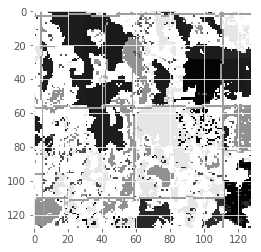

In [177]:
%matplotlib inline
from matplotlib import pyplot as plt


plt.imshow(true_img, cmap='gray')
plt.show()



In [0]:
pred_img = y_test[1].reshape(128,128,255)


In [179]:
print(pred_img.shape)
print(pred_img)


(128, 128, 255)
[[[1.50440099e-13 1.59860647e-04 9.51220168e-14 ... 6.52784033e-14
   1.09168235e-13 1.88489835e-13]
  [1.83619703e-17 1.67856779e-05 8.94689635e-18 ... 2.27399246e-17
   1.09957218e-17 4.95578215e-18]
  [6.76372682e-28 1.84920100e-05 1.61784796e-28 ... 1.33335633e-28
   4.90548320e-28 6.46165433e-28]
  ...
  [1.98445079e-17 3.81216921e-07 1.04902028e-17 ... 4.02216507e-17
   1.05889466e-17 1.02964903e-17]
  [3.88928085e-23 1.61727639e-05 1.30119135e-23 ... 1.12461044e-23
   2.91784093e-23 4.24229295e-23]
  [2.62189229e-16 1.25955878e-04 1.44779729e-16 ... 3.06121281e-16
   1.53857579e-16 7.40668042e-17]]

 [[3.72950742e-19 7.04424465e-08 2.24446691e-18 ... 8.61932280e-19
   3.22871713e-18 6.38504024e-19]
  [9.35864087e-26 7.21615562e-12 1.40476985e-25 ... 3.88534087e-26
   5.27855798e-26 2.42639963e-26]
  [1.30386142e-38 8.34029651e-11 5.77461062e-37 ... 4.18477355e-38
   7.22388954e-37 2.52009404e-38]
  ...
  [5.24208951e-22 2.17152206e-06 4.58970685e-22 ... 3.5644726

In [0]:
pred_img=np.argmax(pred_img,axis=-1)

In [181]:
print(pred_img)
pred_img=pred_img.reshape(128,128)
pred_img=pred_img/255
print(pred_img)

[[195 195 195 ... 195 195 194]
 [195 195 195 ... 195 195 194]
 [194 111 195 ... 121 194 120]
 ...
 [111 111 111 ... 194 194 194]
 [194 194 194 ... 195 175 194]
 [ 61 195 195 ... 194  31  36]]
[[0.76470588 0.76470588 0.76470588 ... 0.76470588 0.76470588 0.76078431]
 [0.76470588 0.76470588 0.76470588 ... 0.76470588 0.76470588 0.76078431]
 [0.76078431 0.43529412 0.76470588 ... 0.4745098  0.76078431 0.47058824]
 ...
 [0.43529412 0.43529412 0.43529412 ... 0.76078431 0.76078431 0.76078431]
 [0.76078431 0.76078431 0.76078431 ... 0.76470588 0.68627451 0.76078431]
 [0.23921569 0.76470588 0.76470588 ... 0.76078431 0.12156863 0.14117647]]


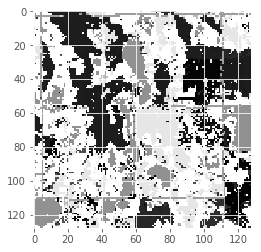

In [182]:
plt.imshow(pred_img, cmap='gray')
plt.show()

In [183]:
colormap = [["#000000","0","0"],
 ["#ffd300","1","1"],
 ["#ff2626","2","2"],
 ["#00a8e2","3","3"],
 ["#ff9e0a","4","4"],
 ["#267000","5","5"],
 ["#ffff00","6","6"],
 ["#000000","7","7"],
 ["#000000","8","8"],
 ["#000000","9","9"],
 ["#70a500","10","10"],
 ["#00af49","11","11"],
 ["#dda50a","12","12"],
 ["#dda50a","13","13"],
 ["#7cd3ff","14","14"],
 ["#000000","15","15"],
 ["#000000","16","16"],
 ["#000000","17","17"],
 ["#000000","18","18"],
 ["#000000","19","19"],
 ["#000000","20","20"],
 ["#e2007c","21","21"],
 ["#896054","22","22"],
 ["#d8b56b","23","23"],
 ["#a57000","24","24"],
 ["#d69ebc","25","25"],
 ["#707000","26","26"],
 ["#aa007c","27","27"],
 ["#a05989","28","28"],
 ["#700049","29","29"],
 ["#d69ebc","30","30"],
 ["#d1ff00","31","31"],
 ["#7c99ff","32","32"],
 ["#d6d600","33","33"],
 ["#d1ff00","34","34"],
 ["#00af49","35","35"],
 ["#ffa5e2","36","36"],
 ["#a5f28c","37","37"],
 ["#00af49","38","38"],
 ["#d69ebc","39","39"],
 ["#000000","40","40"],
 ["#a800e2","41","41"],
 ["#a50000","42","42"],
 ["#702600","43","43"],
 ["#00af49","44","44"],
 ["#af7cff","45","45"],
 ["#702600","46","46"],
 ["#ff6666","47","47"],
 ["#ff6666","48","48"],
 ["#ffcc66","49","49"],
 ["#ff6666","50","50"],
 ["#00af49","51","51"],
 ["#00ddaf","52","52"],
 ["#54ff00","53","53"],
 ["#f2a377","54","54"],
 ["#ff6666","55","55"],
 ["#00af49","56","56"],
 ["#7cd3ff","57","57"],
 ["#e8bfff","58","58"],
 ["#afffdd","59","59"],
 ["#00af49","60","60"],
 ["#bfbf77","61","61"],
 ["#000000","62","62"],
 ["#93cc93","63","63"],
 ["#c6d69e","64","64"],
 ["#ccbfa3","65","65"],
 ["#ff00ff","66","66"],
 ["#ff8eaa","67","67"],
 ["#ba004f","68","68"],
 ["#704489","69","69"],
 ["#007777","70","70"],
 ["#af9970","71","71"],
 ["#ffff7c","72","72"],
 ["#000000","73","73"],
 ["#b5705b","74","74"],
 ["#00a582","75","75"],
 ["#e8d6af","76","76"],
 ["#af9970","77","77"],
 ["#000000","78","78"],
 ["#000000","79","79"],
 ["#000000","80","80"],
 ["#f2f2f2","81","81"],
 ["#999999","82","82"],
 ["#4970a3","83","83"],
 ["#000000","84","84"],
 ["#000000","85","85"],
 ["#000000","86","86"],
 ["#7cafaf","87","87"],
 ["#e8ffbf","88","88"],
 ["#000000","89","89"],
 ["#000000","90","90"],
 ["#000000","91","91"],
 ["#00ffff","92","92"],
 ["#000000","93","93"],
 ["#000000","94","94"],
 ["#000000","95","95"],
 ["#000000","96","96"],
 ["#000000","97","97"],
 ["#000000","98","98"],
 ["#000000","99","99"],
 ["#000000","100","100"],
 ["#000000","101","101"],
 ["#000000","102","102"],
 ["#000000","103","103"],
 ["#000000","104","104"],
 ["#000000","105","105"],
 ["#000000","106","106"],
 ["#000000","107","107"],
 ["#000000","108","108"],
 ["#000000","109","109"],
 ["#000000","110","110"],
 ["#4970a3","111","111"],
 ["#d3e2f9","112","112"],
 ["#000000","113","113"],
 ["#000000","114","114"],
 ["#000000","115","115"],
 ["#000000","116","116"],
 ["#000000","117","117"],
 ["#000000","118","118"],
 ["#000000","119","119"],
 ["#000000","120","120"],
 ["#999999","121","121"],
 ["#999999","122","122"],
 ["#999999","123","123"],
 ["#999999","124","124"],
 ["#000000","125","125"],
 ["#000000","126","126"],
 ["#000000","127","127"],
 ["#000000","128","128"],
 ["#000000","129","129"],
 ["#000000","130","130"],
 ["#ccbfa3","131","131"],
 ["#000000","132","132"],
 ["#000000","133","133"],
 ["#000000","134","134"],
 ["#000000","135","135"],
 ["#000000","136","136"],
 ["#000000","137","137"],
 ["#000000","138","138"],
 ["#000000","139","139"],
 ["#000000","140","140"],
 ["#93cc93","141","141"],
 ["#93cc93","142","142"],
 ["#93cc93","143","143"],
 ["#000000","144","144"],
 ["#000000","145","145"],
 ["#000000","146","146"],
 ["#000000","147","147"],
 ["#000000","148","148"],
 ["#000000","149","149"],
 ["#000000","150","150"],
 ["#000000","151","151"],
 ["#c6d69e","152","152"],
 ["#000000","153","153"],
 ["#000000","154","154"],
 ["#000000","155","155"],
 ["#000000","156","156"],
 ["#000000","157","157"],
 ["#000000","158","158"],
 ["#000000","159","159"],
 ["#000000","160","160"],
 ["#000000","161","161"],
 ["#000000","162","162"],
 ["#000000","163","163"],
 ["#000000","164","164"],
 ["#000000","165","165"],
 ["#000000","166","166"],
 ["#000000","167","167"],
 ["#000000","168","168"],
 ["#000000","169","169"],
 ["#000000","170","170"],
 ["#000000","171","171"],
 ["#000000","172","172"],
 ["#000000","173","173"],
 ["#000000","174","174"],
 ["#000000","175","175"],
 ["#e8ffbf","176","176"],
 ["#000000","177","177"],
 ["#000000","178","178"],
 ["#000000","179","179"],
 ["#000000","180","180"],
 ["#000000","181","181"],
 ["#000000","182","182"],
 ["#000000","183","183"],
 ["#000000","184","184"],
 ["#000000","185","185"],
 ["#000000","186","186"],
 ["#000000","187","187"],
 ["#000000","188","188"],
 ["#000000","189","189"],
 ["#7cafaf","190","190"],
 ["#000000","191","191"],
 ["#000000","192","192"],
 ["#000000","193","193"],
 ["#000000","194","194"],
 ["#7cafaf","195","195"],
 ["#000000","196","196"],
 ["#000000","197","197"],
 ["#000000","198","198"],
 ["#000000","199","199"],
 ["#000000","200","200"],
 ["#000000","201","201"],
 ["#000000","202","202"],
 ["#000000","203","203"],
 ["#00ff8c","204","204"],
 ["#d69ebc","205","205"],
 ["#ff6666","206","206"],
 ["#ff6666","207","207"],
 ["#ff6666","208","208"],
 ["#ff6666","209","209"],
 ["#ff8eaa","210","210"],
 ["#334933","211","211"],
 ["#e27026","212","212"],
 ["#ff6666","213","213"],
 ["#ff6666","214","214"],
 ["#000000","215","215"],
 ["#ff6666","216","216"],
 ["#af9970","217","217"],
 ["#ff8eaa","218","218"],
 ["#ff6666","219","219"],
 ["#ff8eaa","220","220"],
 ["#ff6666","221","221"],
 ["#ff6666","222","222"],
 ["#ff8eaa","223","223"],
 ["#00af49","224","224"],
 ["#ffd300","225","225"],
 ["#ffd300","226","226"],
 ["#ff6666","227","227"],
 ["#000000","228","228"],
 ["#ff6666","229","229"],
 ["#896054","230","230"],
 ["#ff6666","231","231"],
 ["#ff2626","232","232"],
 ["#e2007c","233","233"],
 ["#ff9e0a","234","234"],
 ["#ff9e0a","235","235"],
 ["#a57000","236","236"],
 ["#ffd300","237","237"],
 ["#a57000","238","238"],
 ["#267000","239","239"],
 ["#267000","240","240"],
 ["#ffd300","241","241"],
 ["#000099","242","242"],
 ["#ff6666","243","243"],
 ["#ff6666","244","244"],
 ["#ff6666","245","245"],
 ["#ff6666","246","246"],
 ["#ff6666","247","247"],
 ["#ff6666","248","248"],
 ["#ff6666","249","249"],
 ["#ff6666","250","250"],
 ["#ffd300","251","251"],
 ["#267000","252","252"],
 ["#a57000","253","253"],
 ["#267000","254","254"],
 ["#707000","255","255"]]


def hex_to_rgb(value):
 value = value.lstrip('#')
 lv = len(value)
 return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def getCDLRGB(cdlvalue):
 # print("get cdl:", cdlvalue)
 for x in range(len(colormap)):
   if(int(colormap[x][1])==cdlvalue):
    hex = colormap[x][0]
    rgb = hex_to_rgb(hex)
    return rgb

print("The color of class 5 is: ", getCDLRGB(5))

The color of class 5 is:  (38, 112, 0)


In [0]:
label_colours=[np.array(getCDLRGB(i)) for i in range(0,256)]

label_colours=np.array(label_colours)
def view_mapped(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,256):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()

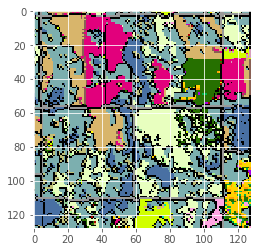

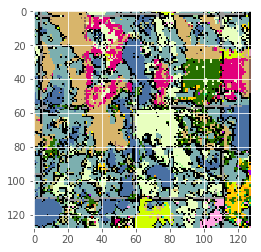

In [185]:
view_mapped(true_img*255)
view_mapped(pred_img*255)